In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch 
import torchvision
import torch.nn as nn 
from IPython.display import Image 
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

In [4]:
cifar10_train = torchvision.datasets.CIFAR10(root='./cifar10', 
                                             train=True, 
                                             transform=None, 
                                             target_transform=None,
                                             download=True)
cifar10_test = torchvision.datasets.CIFAR10(root='./cifar10', 
                                             train=False, 
                                             transform=None, 
                                             target_transform=None,
                                             download=True)

# Divides the dataset into train and val so that we can use the val to choose our hyperparameters
train_dataset, val_dataset = torch.utils.data.random_split(cifar10_train, [40000, 10000], 
                                                           generator=torch.Generator().manual_seed(12345))
test_dataset = cifar10_test

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [5]:
# Helper code to support adding different transforms on the dataset lazily after downloading the dataset
# From https://discuss.pytorch.org/t/apply-different-transform-data-augmentation-to-train-and-validation/63580/5
class MapDataset(torch.utils.data.Dataset):
    """
    Given a dataset, creates a dataset which applies a mapping function
    to its items (lazily, only when an item is called).

    Note that data is not cloned/copied from the initial dataset.
    """

    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        if self.map:     
            x = self.map(self.dataset[index][0]) 
        else:     
            x = self.dataset[index][0]  
        y = self.dataset[index][1]         
        return x, y

    def __len__(self):
        return len(self.dataset)

In [7]:
# Notice that we apply the same mean and std normalization calculated on train, to both the train and test datasets.
test_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         [0.4373, 0.4434, 0.4725],
                                         [0.1201, 0.1231, 0.1052])
                                     ])

train_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.4373, 0.4434, 0.4725],
                                          [0.1201, 0.1231, 0.1052])
                                      ])

train_dataset_w_transform  = MapDataset(train_dataset, train_transform)
val_dataset_w_transform = MapDataset(val_dataset, test_transform)
test_dataset_w_transform = MapDataset(test_dataset, test_transform)

bs = 128
torch.backends.cudnn.benchmark = True
train_loader = DataLoader(train_dataset_w_transform, batch_size=bs, shuffle=True, drop_last=False,num_workers=10, pin_memory=True)
val_loader = DataLoader(val_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False,num_workers=10, pin_memory=True)
test_loader = DataLoader(test_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False,num_workers=10, pin_memory=True)

In [11]:
# Use the description of the structure of the model and the hints given below 

class SimpleConvnet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleConvnet, self).__init__()
        # TODO
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=5, padding=2)
        self.block1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.pool_halve = nn.MaxPool2d(kernel_size=2)
        # self.pool_final = nn.MaxPool2d(kernel_size=8)
        self.linear = nn.Linear(256, num_classes, bias=True)

    
    def forward(self, x):
       
        # TODO 

        # HINT: first conv layer 
        x = self.relu(self.conv1(x))

        # HINT: block of 3 conv 
        x = self.block1(x)
        x = self.pool_halve(x)

        # HINT : block of 3 conv 
        x = self.block2(x)
        x = self.pool_halve(x)

        # HINT: block of 3 conv 
        x = self.block3(x)
        
        # x = self.pool_final(x) # Final max pool
        x = torch.max(torch.max(x, dim=-1)[0], dim=-1)[0] # Generic final max pool, will generate 1x1 no matter input size

        # HINT: projection 
        output = self.linear(x.view(-1,256))
        
        return output

In [8]:
model_path = '/content/drive/My Drive/Fall 2020/1008 Deep Learning/HWs/HW2/results/Q2/simple.pt'
model = torch.load(model_path)

In [15]:
model = SimpleConvnet(3, 10)

checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [16]:
model = model.to(device)
model.eval()

criterion = nn.CrossEntropyLoss(reduction='sum')
test_losses = []
test_accuracies = []
with torch.no_grad():
    n_loss = 0.0
    n_correct = 0
    n_samples = 0
    for i, (inputs, targets) in enumerate(test_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        logits = model(inputs)
        loss = criterion(logits, targets)
        predictions = torch.max(logits, dim=1)[1]
        correct = (predictions == targets).sum().item()

        n_loss += loss.item()
        n_correct += correct
        n_samples += targets.size()[0]
    test_losses.append(n_loss/n_samples)
    test_accuracies.append(n_correct/n_samples)

SimpleConvnet(
  (relu): ReLU()
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (block1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [ ]:
import json

path = '/content/drive/My Drive/Fall 2020/1008 Deep Learning/HWs/HW2/results/Q2.11/'
with open(path+'temp2.json') as f:
  data = json.load(f)

In [ ]:
data['0.05'] = data['0.01']

In [ ]:
# ploting methods
def plot_learning_curves(results_dict, title=None):
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
    for i, key in enumerate(results_dict):
        train_losses, train_accuracies, val_losses, val_accuracies = results_dict[key]
        ax.plot(train_losses, label=f'{key} train', c=colors[i])
        ax.plot(val_losses, label=f'{key} val', c=colors[i], ls=':')
        ax.legend(fontsize=12)
        ax.set_xlabel('epochs',fontsize=12)
        ax.set_ylabel('loss',fontsize=12)
        ax.grid()
    if title:
        fig.suptitle(title,fontsize=15)
    plt.show()

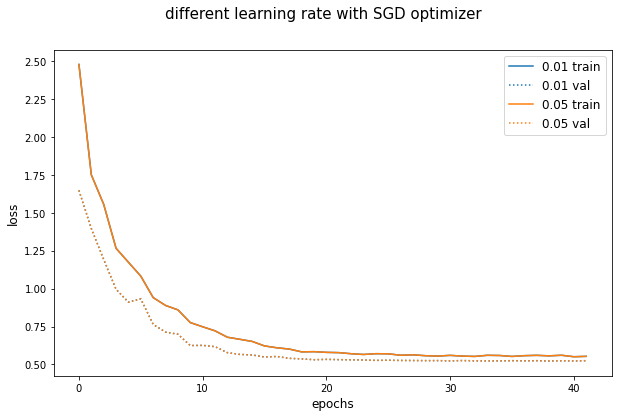

In [ ]:
plot_learning_curves(data, title='different learning rate with SGD optimizer')

In [ ]:
i

0

In [ ]:
def train_loop(model, criterion, optimizer,  train_loader, val_loader, model_name='temp'):
    """
    Generic training loop

    Parameters
    ----------
    model : Object instance of your model class 
    criterion : Loss function 
    optimizer : Instance of optimizer class of your choice 
    train_loader : Training data loader 
    val_loader : Validation data loader

    Returns
    -------
    train_losses : List with train loss on dataset per epoch
    train_accuracies : List with train accuracy on dataset per epoch
    val_losses : List with validation loss on dataset per epoch
    val_accuracies : List with validation accuracy on dataset per epoch

    """
    best_val = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    max_patience = 5
    patience_counter = 0

    # Training
    for t in tqdm(range(50)):

        # TODO : Set the model to train mode 
        model.train()       

        # TODO: Loop over the training set 
        n_loss = 0.0
        n_correct = 0
        n_samples = 0
        for i, (inputs, targets) in enumerate(train_loader):

            # TODO: Put the inputs and targets on the write device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # TODO: Feed forward to get the logits
            logits = model(inputs)

            # TODO: Compute the loss and accuracy
            loss = criterion(logits, targets)
            predictions = torch.max(logits, dim=1)[1]
            correct = (predictions == targets).sum().item()

            # TODO: zero the gradients before running
            # the backward pass.
            optimizer.zero_grad()

            # TODO: Backward pass to compute the gradient
            # of loss w.r.t our learnable params. 
            loss.backward()

            # TODO: Update params
            optimizer.step()
            
            # TODO: Keep track of accuracy and loss
            n_loss += loss.item()
            n_correct += correct
            n_samples += targets.size()[0]
        train_losses.append(n_loss/n_samples)
        train_accuracies.append(n_correct/n_samples)

        
        # TODO: Switch the model to eval mode
        model.eval()


        with torch.no_grad():
            # TODO: Loop over the validation set 
            n_loss = 0.0
            n_correct = 0
            n_samples = 0
            for i, (inputs, targets) in enumerate(val_loader):

                # TODO: Put the inputs and targets on the write device
                inputs = inputs.to(device)
                targets = targets.to(device)
            
                # TODO: Feed forward to get the logits
                logits = model(inputs)

                # TODO: Compute the loss and accuracy
                loss = criterion(logits, targets)
                predictions = torch.max(logits, dim=1)[1]
                correct = (predictions == targets).sum().item()

                # TODO: Keep track of accuracy and loss
                n_loss += loss.item()
                n_correct += correct
                n_samples += targets.size()[0]
            val_losses.append(n_loss/n_samples)
            val_accuracies.append(n_correct/n_samples)

        if val_accuracies[-1] > best_val:
          best_val = val_accuracies[-1]
          patience_counter = 0

          # TODO: Save best model, optimizer, epoch_number
          my_drive_path = '/content/drive/My Drive/Fall 2020/1008 Deep Learning/HWs/HW2'
          torch.save(
              {
               'accuracy': best_val,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'epoch_number': t,
              },
              f'{my_drive_path}/results/Q2/{model_name}.pt'
          )
          
        else:
          patience_counter += 1    
          if patience_counter > max_patience: 
            break

        print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACCURACY]: %.3f" % (t, train_losses[-1], train_accuracies[-1]))
        print("[EPOCH]: %i, [VAL LOSS]: %.6f, [VAL ACCURACY]: %.3f \n" % (t, val_losses[-1] ,val_accuracies[-1]))

    return train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
# TODO : Initialize the model and cast to correct device
res_model_reduce_overfit = ResidualConvnet(3, 10).to(device)

# TODO : Initialize the criterion 
criterion = nn.CrossEntropyLoss(reduction='sum')

# TODO : Initialize the optimizer 
optimizer = torch.optim.SGD(res_model_reduce_overfit.parameters(), lr=1e-3)

# TODO : Run the training loop using this model
residual_reduce_overfit_results = train_loop(res_model_reduce_overfit, criterion, optimizer,  train_loader, val_loader, model_name='residual_reduce_overfit_2')

In [ ]:
import torch 
import torchvision
import torch.nn as nn 
from IPython.display import Image 
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
import PIL
import requests

In [ ]:
# Q4
# imagenet_transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225]),
#         ])

# Notice that we apply the same mean and std normalization calculated on train, to both the train and test datasets.
imagenet_transform = transforms.Compose([
                                     transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
                                     ])
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
make_viewable = transforms.Compose([
    inv_normalize,
    transforms.ToPILImage()
])

pil = transforms.ToPILImage()

In [ ]:
url = "https://cdn.wimmel-napkins.com/F/1/AM/g13312895.jpg"
im = PIL.Image.open(requests.get(url, stream=True).raw).convert("RGB")

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im2 = PIL.Image.open(requests.get(url, stream=True).raw).convert("RGB")
im2 = im2.resize((int(im2.size[0] *2.5), int(im2.size[1] * 2.5)))

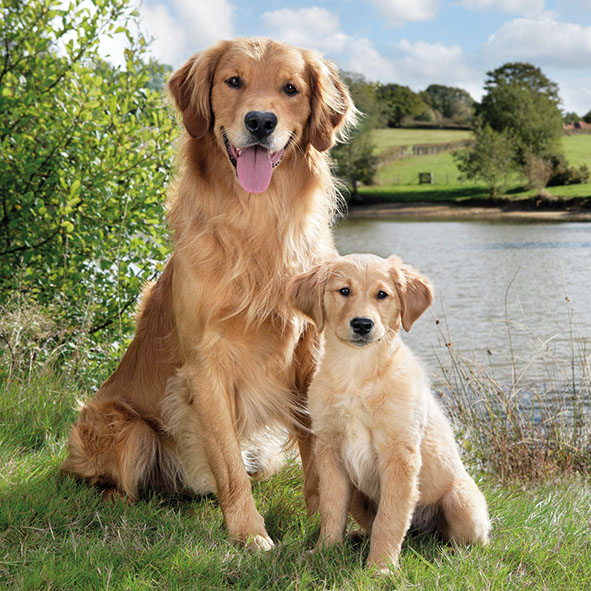

In [ ]:
im

In [ ]:
                                     ])
'''
RandomApply, RandomChoice, RandomOrder

Candidate transforms
    ColorJitter:        Randomly change the brightness, contrast and saturation of an image.
    RandomAffine:       Random affine transformation of the image keeping center invariant.
    RandomCrop:         Crop the given PIL Image at a random location.
    RandomGrayscale:    Randomly convert image to grayscale with a probability of p (default 0.1)
    RandomHorizontalFlip: Horizontally flip the given image randomly with a given probability.
    RandomPerspective:  Performs Perspective transformation of the given PIL Image randomly with a given probability.
    RandomRotation:     Rotate the image by angle.
    RandomVerticalFlip: Vertically flip the given PIL Image randomly with a given probability.
    RandomErasing:      Randomly selects a rectangle region in an image and erases its pixels.
'''

train_transform = transforms.Compose([
                                      # TODO: Add more transforms here 
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.4373, 0.4434, 0.4725],
                                          [0.1201, 0.1231, 0.1052])
                                      ])


5

In [ ]:
temp = transforms.Compose([
                           transforms.RandomApply(
                           [transforms.ColorJitter(0.5,0.5,0.5,0.5),
                            transforms.RandomAffine(degrees=10, translate=(0.25,0.25), scale=(1,1.5), shear=20),
                            transforms.RandomPerspective(),
                            transforms.RandomVerticalFlip(),
                            transforms.RandomHorizontalFlip()], p=0.5),
                            
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
                            ])

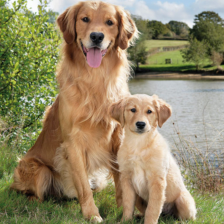

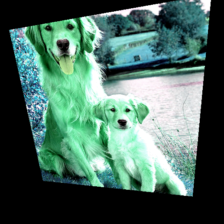

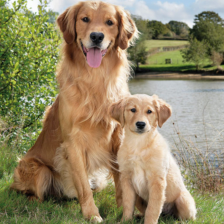

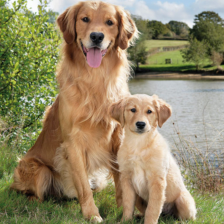

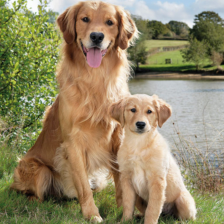

In [ ]:
for i in range(5):
    display(make_viewable(temp(im)))

In [ ]:
temp = transforms.Compose([
                           transforms.RandomApply(
                           [transforms.RandomChoice(
                            [transforms.ColorJitter(0.5,0.5,0.5,0.5),
                            transforms.RandomAffine(degrees=10, translate=(0.25,0.25), scale=(1,1.5), shear=20),
                            transforms.RandomPerspective(),
                            transforms.RandomVerticalFlip(),
                            transforms.RandomHorizontalFlip()])], p=0.5),
                            
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
                            ])

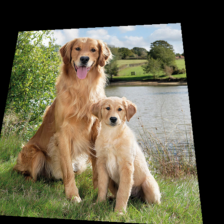

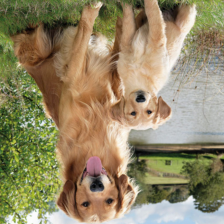

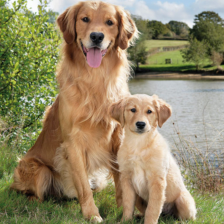

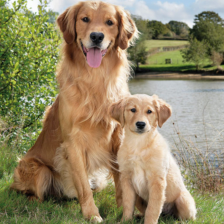

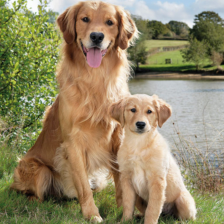

In [ ]:
for i in range(5):
    display(make_viewable(temp(im)))

### HorizontalFlip & VerticalFlip

In [ ]:
temp = transforms.Compose([
                           transforms.RandomVerticalFlip(),
                           transforms.RandomHorizontalFlip(),
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
                            ])

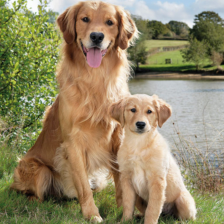

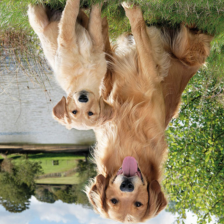

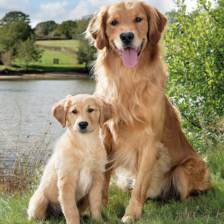

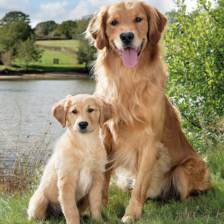

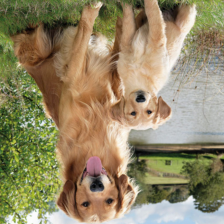

In [ ]:
for i in range(5):
    display(make_viewable(temp(im)))

### RandomErasing (no good)

In [ ]:
temp = transforms.Compose([
                           transforms.RandomErasing(),
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
                            ])

In [ ]:
for i in range(5):
    display(make_viewable(temp(im)))

AttributeError: ignored

### Color

In [ ]:
temp = transforms.Compose([
                           transforms.ColorJitter(0.5,0.5,0.5,0.5),
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
                            ])

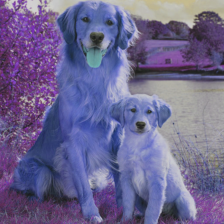

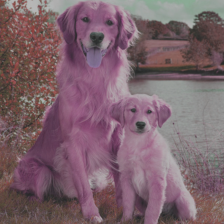

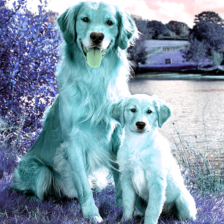

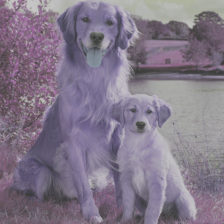

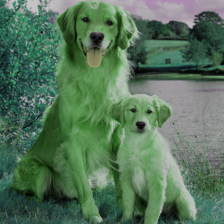

In [ ]:
for i in range(5):
    display(make_viewable(temp(im)))

### Afine

In [ ]:
temp = transforms.Compose([
                           transforms.RandomAffine(degrees=10, translate=(0.25,0.25), scale=(1,1.5), shear=20),
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
                            ])

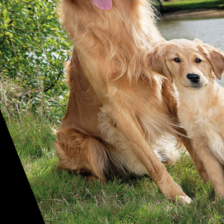

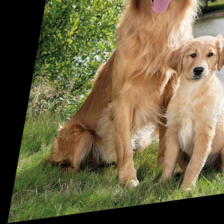

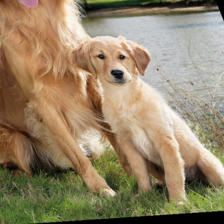

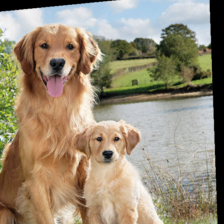

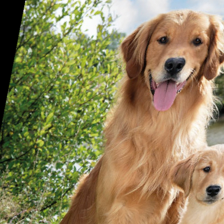

In [ ]:
for i in range(5):
    display(make_viewable(temp(im)))

### RandomPerspective

In [ ]:
temp = transforms.Compose([
                           transforms.RandomPerspective(),
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
                            ])

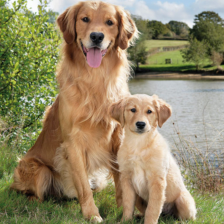

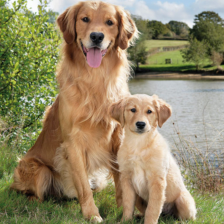

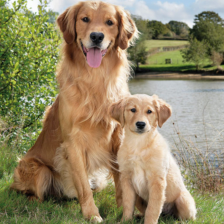

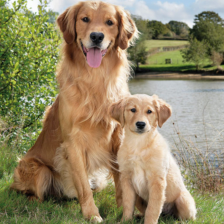

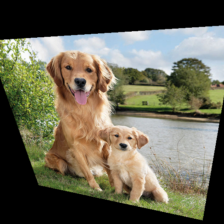

In [ ]:
for i in range(5):
    display(make_viewable(temp(im)))